In [1]:
import pyvista as pv
pv.start_xvfb(wait=0)
pv.set_jupyter_backend('html')

import os
import sys
sys.path.append(os.path.join('..', '.'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from pytorch3d.structures import Meshes
from pytorch3d.io import load_objs_as_meshes, save_obj
from pytorch3d.ops import cubify, cot_laplacian, sample_points_from_meshes, knn_points, knn_gather, norm_laplacian, taubin_smoothing
from pytorch3d.loss import chamfer_distance
from pytorch3d.utils import ico_sphere

from torch_geometric.utils import degree, to_undirected, to_dense_adj, get_laplacian, add_self_loops
from torch_geometric.data import Data
# from torch_geometric.transforms import gdc
from torch_scatter import scatter

import numpy as np

import trimesh


from scipy.sparse.linalg import eigsh
from scipy.sparse import coo_matrix


from data_process.dataset_real_scaling import UKBB_dataset, MMWHS_dataset, ACDC_dataset, CCT48_dataset
from ops.graph_operators import NativeFeaturePropagation, LaplacianSmoothing
from data.dataset import MMWHSDataset_3DLabel


from tqdm import tqdm

from probreg import cpd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pytorch3d.transforms import axis_angle_to_matrix, matrix_to_axis_angle


import warnings
warnings.filterwarnings("ignore")

from GHD import GHD_config, GHDmesh, Normal_iterative_GHDmesh
from GHD.GHD_cardiac import GHD_Cardiac

from einops import rearrange, einsum, repeat

from pytorch3d.loss import chamfer_distance,mesh_laplacian_smoothing, mesh_normal_consistency, mesh_edge_loss


from losses import *
from ops.mesh_geometry import *

import data.data_utils as dut
from ops.medical_related import *



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
base_shape_path = '../canonical_shapes/Standard_LV_4055.obj'
bi_ventricle_path = '../canonical_shapes/Standard_BiV.obj'

# base_shape_path = 'metadata/Standard_LV.obj'
# bi_ventricle_path = 'metadata/Standard_BiV.obj'

cfg = GHD_config(base_shape_path=base_shape_path,
            num_basis=9**2, mix_laplacian_tradeoff={'cotlap':1.0, 'dislap':0.1, 'stdlap':0.1},
            device='cuda:1',
            if_nomalize=True, if_return_scipy=True, 
            bi_ventricle_path=bi_ventricle_path)

paraheart = GHD_Cardiac(cfg) # 

GHD config:
base_shape_path ../canonical_shapes/Standard_LV_4055.obj
num_basis 81
device cuda:1
mix_laplacian_tradeoff {'cotlap': 1.0, 'dislap': 0.1, 'stdlap': 0.1}
if_lap_nomalize True
eign_path None
if_nomalize True
if_return_scipy True
bi_ventricle_path ../canonical_shapes/Standard_BiV.obj


In [3]:

dataset = MMWHSDataset_3DLabel(output_shape=None,dataset_path='../../../Dataset/MMWHS', modality='mixed', RML_simple=1)
                            

In [4]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=8)

query_num = 1000

device = paraheart.device


for i, example in enumerate(dataloader):

    image_tem = example['image'].to(device)
    affine_tem = example['affine'].to(device)
    label_tem = example['label'].to(device)

    # mesh_gt_lv = cubify((label_tem==dataset.label_value[2]).squeeze(1).float(), 0.48)
    # mesh_gt_lv = taubin_smoothing(mesh_gt_lv, 0.1, 0.5, num_iter=20)
    
    B = image_tem.shape[0]
    ## -------------- Data augmentation -----------------##
    coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], affine_tem)

    lv_cavity_index =  torch.where(label_tem==2)
    lv_cavity_center = coordinate_map_tem[lv_cavity_index[0],lv_cavity_index[2],lv_cavity_index[3],lv_cavity_index[4],:]
    lv_cavity_center = scatter(lv_cavity_center, lv_cavity_index[0], dim=0, reduce='mean')

    

    affine_aug  = dut.random_affine(B=B, dim=3, rot_range=[-np.pi, np.pi], 
                                    scale_range=[1.,1.], trans_range=[-0.2,0.2]).to(device)
    
    affine_aug[...,:3, 3] = affine_aug[...,:3, 3] + lv_cavity_center 

    del lv_cavity_center, lv_cavity_index

    Z_new, Y_new, X_new = 128, 128, 128

    Z_new = np.random.randint(32, 64)

    with torch.no_grad():
        new_affine = affine_tem.inverse()@affine_aug

        new_affine_inv = new_affine.inverse()

        # mesh_gt_lv = mesh_gt_lv.update_padded(mesh_gt_lv.verts_padded().matmul(new_affine_inv[..., :3,:3].transpose(-1,-2))+new_affine_inv[...,:3,3].unsqueeze(-2))

        label_tem = dut.augment_from_affine(label_tem, new_affine, (Z_new, Y_new, X_new), mode='nearest')
        image_tem = dut.augment_from_affine(image_tem, new_affine, (Z_new, Y_new, X_new), mode='bilinear')

        example['label'] = label_tem
        example['image'] = image_tem


        image_tem = dut.img_standardize(image_tem)
        image_tem =dut.img_normalize(image_tem)

        
        coordinate_map_tem = dut.get_coord_map_3d_normalized(image_tem.shape[-3:], torch.eye(4).to(device).unsqueeze(0).repeat(B,1,1))
        
        B, C, Z, Y, X = image_tem.shape


        query_points_labeled = rearrange(coordinate_map_tem, 
                                            'b z y x c -> b (z y x) c', c=3)
        query_points_labeled = torch.cat([query_points_labeled, 
                                        rearrange(label_tem==dataset.label_value[2], 'b 1 z y x -> b (z y x) 1')], dim=-1)
        
        query_points_list = []
        target_affine_list = []
        
        Z_rv, Y_rv, X_rv = torch.where(label_tem[0, 0]==dataset.label_value[1])
        Z_lv, Y_lv, X_lv = torch.where(label_tem[0, 0]==dataset.label_value[2])
        Z_cav, Y_cav, X_cav = torch.where(label_tem[0, 0]==dataset.label_value[3])
        Z_bg, Y_bg, X_bg = torch.where(label_tem[0, 0]==dataset.label_value[0])
        
        Pt_rv = coordinate_map_tem[0, Z_rv, Y_rv, X_rv]
        Pt_lv = coordinate_map_tem[0, Z_lv, Y_lv, X_lv]
        Pt_cav = coordinate_map_tem[0, Z_cav, Y_cav, X_cav]
        Pt_bg = coordinate_map_tem[0, Z_bg, Y_bg, X_bg]

        points_bi = torch.cat([Pt_rv, Pt_lv], dim=0)
        points_lv = Pt_lv
        points_outoflv = torch.cat([Pt_rv, Pt_cav, Pt_bg], dim=0)

        geom_dict = get_4chamberview_frame(Pt_cav, Pt_lv, Pt_rv)
        inital_affine = geom_dict['target_affine']



        bbox_lv = torch.stack([Pt_lv.min(dim=0)[0]-0.05, Pt_lv.max(dim=0)[0]+0.05], dim=-1)

        points_outoflv_in_bbox = points_outoflv[(points_outoflv[:,0]>bbox_lv[0,0]) & (points_outoflv[:,0]<bbox_lv[0,1]) & (points_outoflv[:,1]>bbox_lv[1,0]) & (points_outoflv[:,1]<bbox_lv[1,1]) & (points_outoflv[:,2]>bbox_lv[2,0]) & (points_outoflv[:,2]<bbox_lv[2,1])]

    break

mesh_gt_lv = cubify((label_tem==dataset.label_value[2]).squeeze(1).float(), 0.48)

paraheart.R = matrix_to_axis_angle(inital_affine[...,:3,:3].to(paraheart.device)).view(paraheart.R.shape)
paraheart.T = inital_affine[...,:3,3].to(paraheart.device).view(paraheart.T.shape)


In [5]:
sample_num = 2000

mesh_gt_bi_sample = points_bi.detach().cpu().numpy()[np.random.choice(points_bi.shape[0], sample_num, replace=False)]
paraheart.global_registration_biv(mesh_gt_bi_sample)


sample_lv = points_lv[np.random.choice(points_lv.shape[0], sample_num, replace=False)]
sample_outoflv = points_outoflv_in_bbox[np.random.choice(points_outoflv_in_bbox.shape[0], sample_num, replace=False)]
paraheart.global_registration_lv(sample_lv.detach().cpu().numpy())

{'rot': array([[ 0.19652285, -0.58808682, -0.78455889],
        [-0.61505332, -0.69709681,  0.36846364],
        [-0.76360211,  0.41013403, -0.4987002 ]]),
 'scale': 1.2777744542283105,
 't': array([-0.27861619,  0.06749218,  0.10036034])}

In [6]:

coordinate_map_np = coordinate_map_tem[0].detach().cpu().numpy()

pl = pv.Plotter(notebook=True)
interval = 1
if image_tem.shape[-3] > 20:
    interval = 2
if image_tem.shape[-3] > 256:
    interval = 10
for i in range(0, image_tem.shape[-3], interval):

    x, y, z = coordinate_map_np[i,...,0], coordinate_map_np[i,...,1], coordinate_map_np[i,...,2]

    grid = pv.StructuredGrid(x, y, z)

    color_gt = (label_tem[0,0,i].cpu().numpy().T.flatten() ==2).astype(np.float32)
    
    raw_image = image_tem[0,0,i].cpu().numpy().T.flatten()

    color_opacity = np.ones_like(color_gt)*0.8

    color_opacity[color_gt == 0] = 0.2


    color_gt = raw_image*(1-color_gt) + color_gt


    pl.add_mesh(grid, scalars = color_gt, cmap = 'gray_r',
                show_scalar_bar = False, opacity = color_opacity, clim=[0,1])
    
out_ghd_mesh = paraheart.rendering()

# trimesh_current_bi = paraheart.rendering_bi_ventricle()
# trimesh_current_bi = pv.wrap(trimesh_current_bi)
# pl.add_mesh(trimesh_current_bi, color='blue', opacity=0.2)

trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)

trimesh_current_lv = trimesh.Trimesh(out_ghd_mesh.verts_packed().detach().cpu().numpy(), out_ghd_mesh.faces_packed().detach().cpu().numpy())
pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.8, show_edges=True, show_vertices=False)

pl.add_points(sample_lv.detach().cpu().numpy(), color='green', point_size=5)
pl.add_points(sample_outoflv.detach().cpu().numpy(), color='red', point_size=2)


pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')

# pl.add_points(lv_cavity_center.cpu().numpy(), color='red', point_size=10)

pl.add_axes()
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [9]:

# sample_outoflv = points_outoflv_in_bbox[np.random.choice(points_outoflv_in_bbox.shape[0], sample_num*5, replace=False)]

convergence, Loss_dict_list  = paraheart.morphing2lvtarget(points_lv, points_outoflv_in_bbox, 
                                                           loss_dict = {'Loss_occupancy':1, 'Loss_Laplacian':0.001, 'Loss_thickness': 0.001},
                                                            lr_start=1e-3, num_iter=2000, if_reset=True, if_fit_R=False, if_fit_s=True, if_fit_T=True, record_convergence=True)

Total Loss 0.1071: 100%|██████████| 2000/2000 [01:52<00:00, 17.71it/s]

fittings done, the final loss is 0.107143


In [10]:
Dice = 1 - paraheart.dice_evaluation(points_lv, points_outoflv_in_bbox)

print('Final Dice: ' + str(Dice*100) + '%')

Final Dice: 80.40750026702881%


In [11]:

coordinate_map_np = coordinate_map_tem[0].detach().cpu().numpy()

pl = pv.Plotter(notebook=True, shape=(1,3))
pl.subplot(0,0)
interval = 1
if image_tem.shape[-3] > 20:
    interval = 5
if image_tem.shape[-3] > 256:
    interval = 10
for i in range(0, image_tem.shape[-3], interval):

    x, y, z = coordinate_map_np[i,...,0], coordinate_map_np[i,...,1], coordinate_map_np[i,...,2]

    grid = pv.StructuredGrid(x, y, z)

    color_gt = (label_tem[0,0,i].cpu().numpy().T.flatten() ==2).astype(np.float32)
    
    raw_image = image_tem[0,0,i].cpu().numpy().T.flatten()

    color_opacity = np.ones_like(color_gt)*0.8

    color_opacity[color_gt == 0] = 0.2


    color_gt = raw_image*(1-color_gt) + color_gt


    pl.add_mesh(grid, scalars = color_gt, cmap = 'gray_r',
                show_scalar_bar = False, opacity = color_opacity, clim=[0,1])
    
out_ghd_mesh = paraheart.rendering()

# trimesh_current_bi = paraheart.rendering_bi_ventricle()
# trimesh_current_bi = pv.wrap(trimesh_current_bi)
# pl.add_mesh(trimesh_current_bi, color='blue', opacity=0.2)

# trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
# pl.add_mesh(trimesh_gt_lv, color='lightgreen', opacity=0.1)

trimesh_current_lv = trimesh.Trimesh(out_ghd_mesh.verts_packed().detach().cpu().numpy(), out_ghd_mesh.faces_packed().detach().cpu().numpy())
pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=0.8, show_edges=True, show_vertices=False)

pl.add_points(sample_lv.detach().cpu().numpy(), color='green', point_size=5)
# pl.add_points(sample_outoflv.detach().cpu().numpy(), color='red', point_size=2)


pl.add_mesh(pv.Box(bounds=[-1, 1, -1, 1, -1, 1]).outline(), color='black')

# pl.add_points(lv_cavity_center.cpu().numpy(), color='red', point_size=10)
pl.add_axes()

pl.subplot(0,1)
pl.add_mesh(trimesh_current_lv, color='lightblue', opacity=1, show_edges=True, show_vertices=1)

pl.add_axes()
pl.subplot(0,2)
trimesh_gt_lv = trimesh.Trimesh(mesh_gt_lv.verts_packed().detach().cpu().numpy(), mesh_gt_lv.faces_packed().detach().cpu().numpy())
pl.add_mesh(trimesh_gt_lv, color='lightcoral', opacity=1, show_edges=True, show_vertices=0)

pl.add_axes()
pl.show()

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

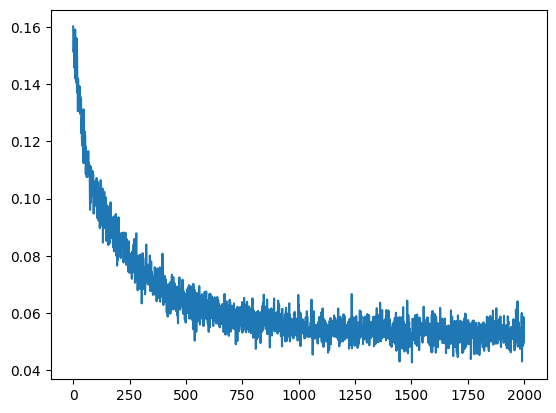

In [10]:
Loss_occupancy = [loss['Loss_occupancy'] for loss in Loss_dict_list]
Loss_occupancy = np.array(Loss_occupancy)
plt.plot(Loss_occupancy)